# The Nature Conservancy Fisheries Monitoring

https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring

In [ ]:
import cv2
import numpy as np
import pandas as pd

from random import shuffle

from sklearn.metrics import log_loss

import tensorflow as tf
from tensorflow.keras.applications import vgg16
from tensorflow.keras.optimizers import SGD

print(tf.__version__)

2.17.1


In [ ]:
import glob
import os
import zipfile
import shutil

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# все распаковываем
with zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/10_Компьютерное зрение/the-nature-conservancy-fisheries-monitoring/train.zip') as train_zip:
     train_zip.extractall('.')


In [ ]:
with zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/10_Компьютерное зрение/the-nature-conservancy-fisheries-monitoring/test_stg1.zip') as test_zip:
     test_zip.extractall('.')

with zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/10_Компьютерное зрение/the-nature-conservancy-fisheries-monitoring/sample_submission_stg1.csv.zip') as test_zip:
     test_zip.extractall('.')

In [ ]:
!pip install py7zr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 94.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.3/141.3 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.7/413.7 kB 38.7 MB/s eta 0:00:00


In [ ]:
from py7zr import SevenZipFile

In [ ]:
with SevenZipFile('/content/drive/MyDrive/Colab Notebooks/10_Компьютерное зрение/the-nature-conservancy-fisheries-monitoring/test_stg2.7z', 'r') as archive:
    archive.extractall()

In [ ]:
# !7z x test_stg2.7z
# # загрузим data/fish/boxes/*.json
# #!7z x fish_data.7z -o./data
# !7z x -y fish_data.7z

# Загружаем разметку

In [ ]:
import os
import json
from glob import glob

TRAIN_PREFIX = '/content/train'

def load_annotations():
    boxes = dict()
    for path in glob('/content/drive/MyDrive/Colab Notebooks/10_Компьютерное зрение/the-nature-conservancy-fisheries-monitoring/boxes/*.json'):
        label = os.path.basename(path).split('_', 1)[0]
        with open(path) as src:
            for annotation in json.load(src):
                basename = os.path.basename(annotation['filename'])
                annotation['filename'] = os.path.join(
                    TRAIN_PREFIX, label.upper(), basename)
                for rect in annotation['annotations']:
                    rect['x'] += rect['width'] / 2
                    rect['y'] += rect['height'] / 2
                if os.path.isfile(annotation['filename']):
                    boxes.setdefault(label, []).append(annotation)
    return boxes

def draw_boxes(annotation, rectangles=None, image_size=None):

    def _draw(img, rectangles, scale_x, scale_y, color=(0, 255, 0)):
        for rect in rectangles:
            pt1 = (int((rect['x'] - rect['width'] / 2) * scale_x),
                   int((rect['y'] - rect['height'] / 2) * scale_y))
            pt2 = (int((rect['x'] + rect['width'] / 2) * scale_x),
                   int((rect['y'] + rect['height'] / 2) * scale_y))
            img = cv2.rectangle(img.copy(), pt1, pt2,
                                color=color, thickness=4)
        return img

    scale_x, scale_y = 1., 1.

    img = cv2.imread(annotation['filename'], cv2.IMREAD_COLOR)[...,::-1]
    if image_size is not None:
        scale_x = 1. * image_size[0] / img.shape[1]
        scale_y = 1. * image_size[1] / img.shape[0]
        img = cv2.resize(img, image_size)

    img = _draw(img, annotation.get('annotations', []), scale_x, scale_y)

    if rectangles is not None:
        img = _draw(img, rectangles, 1., 1., (255, 0, 0))

    return img

### Визуализируем разметку

In [ ]:
boxes = load_annotations()  # загружаем разметку детекций

In [ ]:
pd.DataFrame(
    [(k, len(v)) for k, v in boxes.items()],
    columns=['class', 'count'])

class  count
0    alb   1719
1    bet    200
2    dol    117
3    lag     67
4  shark    176
5    yft    734

In [ ]:
train_files = glob('/content/train/*/*.jpg')
test_files = glob('/content/test_stg1/*.jpg')
test_files += glob('/content/test_stg2/*.jpg')


In [ ]:
from collections import Counter
classes = Counter([path.split('/')[-2] for path in train_files])
classes = {key: i for i, key in enumerate(classes.keys())}
classes

{'SHARK': 0,
 'OTHER': 1,
 'ALB': 2,
 'LAG': 3,
 'YFT': 4,
 'BET': 5,
 'NoF': 6,
 'DOL': 7}

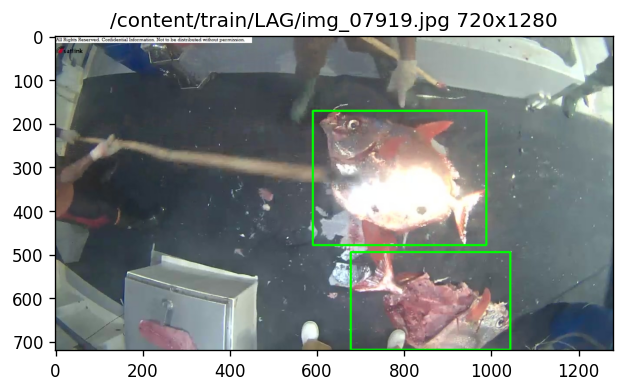

In [ ]:
from matplotlib import pyplot as plt


annotation = boxes['lag'][0]
img = draw_boxes(annotation)

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(img)
plt.title('{} {}x{}'.format(
    annotation['filename'], img.shape[0], img.shape[1]));

### Распределение размеров разметки

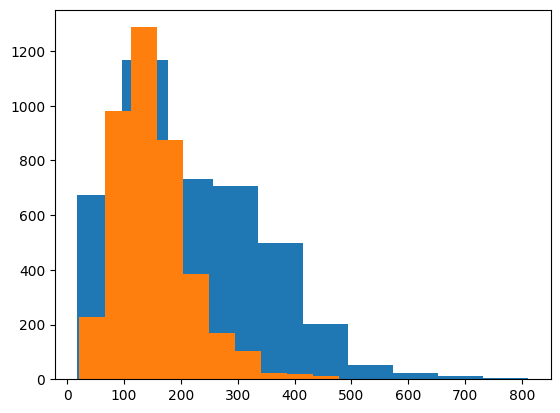

In [ ]:
annotations = sum([box['annotations']
                   for box in sum(boxes.values(), [])], [])

widths = [rect['width'] for rect in annotations]
heights = [rect['height'] for rect in annotations]

plt.hist(widths)
plt.hist(heights);

# Экстрактор признаков

In [ ]:
IMG_HEIGHT = 750
IMG_WIDTH = 1200

features = vgg16.VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# дообучаем последние 5 слоев
for layer in features.layers[:-5]:
    layer.trainable = False

feature_tensor = features.layers[-1].output
print(feature_tensor.shape)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(None, 23, 37, 512)


# Сетка якорей (anchor grid)

In [ ]:
FEATURE_SHAPE = (feature_tensor.shape[1],
                 feature_tensor.shape[2])

GRID_STEP_H = IMG_HEIGHT / FEATURE_SHAPE[0]
GRID_STEP_W = IMG_WIDTH / FEATURE_SHAPE[1]

ANCHOR_WIDTH = 150.
ANCHOR_HEIGHT = 150.

# сетка якорей, размер определяется соотношением
# размера входного изображения и размером тензора признаков
ANCHOR_CENTERS = np.mgrid[GRID_STEP_H/2:IMG_HEIGHT:GRID_STEP_H,
                          GRID_STEP_W/2:IMG_WIDTH:GRID_STEP_W]

In [ ]:
def iou(rect, x_scale, y_scale, anchor_x, anchor_y,
        anchor_w=ANCHOR_WIDTH, anchor_h=ANCHOR_HEIGHT):

    rect_x1 = (rect['x'] - rect['width'] / 2) * x_scale
    rect_x2 = (rect['x'] + rect['width'] / 2) * x_scale

    rect_y1 = (rect['y'] - rect['height'] / 2) * y_scale
    rect_y2 = (rect['y'] + rect['height'] / 2) * y_scale

    anch_x1, anch_x2 = anchor_x - anchor_w / 2, anchor_x + anchor_w / 2
    anch_y1, anch_y2 = anchor_y - anchor_h / 2, anchor_y + anchor_h / 2

    dx = (min(rect_x2, anch_x2) - max(rect_x1, anch_x1))
    dy = (min(rect_y2, anch_y2) - max(rect_y1, anch_y1))

    intersection = dx * dy if (dx > 0 and dy > 0) else 0.

    anch_square = (anch_x2 - anch_x1) * (anch_y2 - anch_y1)
    rect_square = (rect_x2 - rect_x1) * (rect_y2 - rect_y1)
    union = anch_square + rect_square - intersection

    return intersection / union

def encode_anchors(annotation, img_shape, iou_thr=0.5):
    encoded = np.zeros(shape=(FEATURE_SHAPE[0],
                              FEATURE_SHAPE[1], 5), dtype=np.float32)
    x_scale = 1. * IMG_WIDTH / img_shape[1]
    y_scale = 1. * IMG_HEIGHT / img_shape[0]
    for rect in annotation['annotations']:
        scores = []
        for row in range(FEATURE_SHAPE[0]):
            for col in range(FEATURE_SHAPE[1]):
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                score = iou(rect, x_scale, y_scale, anchor_x, anchor_y)
                scores.append((score, anchor_x, anchor_y, row, col))

        scores = sorted(scores, reverse=True)
        if scores[0][0] < iou_thr:
            scores = [scores[0]]  # default anchor
        else:
            scores = [e for e in scores if e[0] > iou_thr]

        for score, anchor_x, anchor_y, row, col in scores:
            dx = (anchor_x - rect['x'] * x_scale) / ANCHOR_WIDTH
            dy = (anchor_y - rect['y'] * y_scale) / ANCHOR_HEIGHT
            dw = (ANCHOR_WIDTH - rect['width'] * x_scale) / ANCHOR_WIDTH
            dh = (ANCHOR_HEIGHT - rect['height'] * y_scale) / ANCHOR_HEIGHT
            encoded[row, col] = [1., dx, dy, dw, dh]

    return encoded

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def decode_prediction(prediction, conf_thr=0.1):
    rectangles = []
    for row in range(FEATURE_SHAPE[0]):
        for col in range(FEATURE_SHAPE[1]):
            logit, dx, dy, dw, dh = prediction[row, col]
            conf = _sigmoid(logit)
            if conf > conf_thr:
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                rectangles.append({'x': anchor_x - dx * ANCHOR_WIDTH,
                                   'y': anchor_y - dy * ANCHOR_HEIGHT,
                                   'width': ANCHOR_WIDTH - dw * ANCHOR_WIDTH,
                                   'height': ANCHOR_HEIGHT - dh * ANCHOR_HEIGHT,
                                   'conf': conf})
    return rectangles

def non_max_suppression(rectangles, max_output_size, iou_threshold=0.5):
    if not rectangles:
        return rectangles

    boxes = [[r['y'],
              r['x'],
              r['y'] + r['height'],
              r['x'] + r['width']] for r in rectangles]
    scores = [r['conf'] for r in rectangles]
    indices = tf.image.non_max_suppression(np.array(boxes),
                                           np.array(scores),
                                           max_output_size,
                                           iou_threshold)

    return [rectangles[i] for i in indices]

### Валидация энкодинга/декодинга якорей

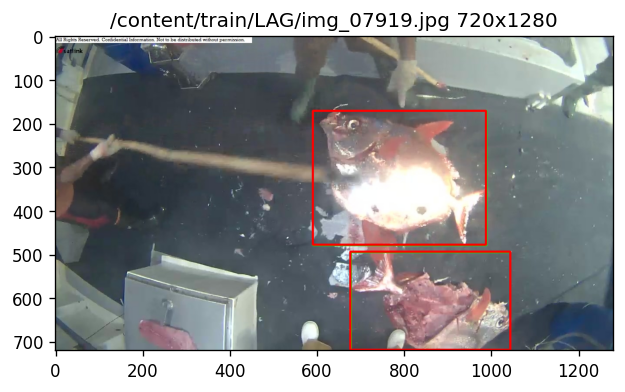

In [ ]:
annotation = boxes['lag'][0]

encoded = encode_anchors(annotation,
                         img_shape=(IMG_HEIGHT, IMG_WIDTH),
                         iou_thr=0.5)

decoded = decode_prediction(encoded, conf_thr=0.7)
decoded = sorted(decoded, key = lambda e: -e['conf'])

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(draw_boxes(annotation, decoded))
plt.title('{} {}x{}'.format(
    annotation['filename'], img.shape[0], img.shape[1]));

## Функция потерь

In [ ]:
K = tf.keras.backend

def confidence_loss(y_true, y_pred):
    conf_loss = K.binary_crossentropy(y_true[..., 0],
                                      y_pred[..., 0],
                                      from_logits=True)
    return conf_loss

def smooth_l1(y_true, y_pred):
    abs_loss = K.abs(y_true[..., 1:] - y_pred[..., 1:])
    square_loss = 0.5 * K.square(y_true[..., 1:] - y_pred[..., 1:])
    mask = K.cast(K.greater(abs_loss, 1.), 'float32')
    total_loss = (abs_loss - 0.5) * mask + 0.5 * square_loss * (1. - mask)
    return K.sum(total_loss, axis=-1)

def total_loss(y_true, y_pred, neg_pos_ratio=3):
    batch_size = K.shape(y_true)[0]

    # TODO: добавьте функцию потерь для классификации детекции

    y_true = K.reshape(y_true, (batch_size, -1, 5))
    y_pred = K.reshape(y_pred, (batch_size, -1, 5))

    # confidence loss
    conf_loss = confidence_loss(y_true, y_pred)

    # smooth l1 loss
    loc_loss = smooth_l1(y_true, y_pred)

    # positive examples loss
    pos_conf_loss = K.sum(conf_loss * y_true[..., 0], axis=-1)
    pos_loc_loss = K.sum(loc_loss * y_true[..., 0], axis=-1)

    # negative examples loss
    anchors = K.shape(y_true)[1]
    num_pos = K.sum(y_true[..., 0], axis=-1)
    num_pos_avg = K.mean(num_pos)
    num_neg = K.min([neg_pos_ratio * (num_pos_avg) + 1., K.cast(anchors, 'float32')])

    # hard negative mining
    neg_conf_loss, _ = tf.nn.top_k(conf_loss * (1. - y_true[..., 0]),
                                   k=K.cast(num_neg, 'int32'))

    neg_conf_loss = K.sum(neg_conf_loss, axis=-1)

    # total conf loss
    total_conf_loss = (neg_conf_loss + pos_conf_loss) / (num_neg + num_pos + 1e-32)
    loc_loss = pos_loc_loss / (num_pos + 1e-32)

    return total_conf_loss + 0.5 * loc_loss

## Загрузка данных

In [ ]:
from random import shuffle

def load_img(path, target_size=(IMG_WIDTH, IMG_HEIGHT)):
    img = cv2.imread(path, cv2.IMREAD_COLOR)[...,::-1]
    img_shape = img.shape
    img_resized = cv2.resize(img, target_size)
    return img_shape, vgg16.preprocess_input(img_resized.astype(np.float32))

def data_generator(boxes, batch_size=32):
    boxes = sum(boxes.values(), [])
    while True:
        shuffle(boxes)
        for i in range(len(boxes)//batch_size):
            X, y = [], []
            for j in range(i*batch_size,(i+1)*batch_size):
                img_shape, img = load_img(boxes[j]['filename'])
                # TODO: добавьте one-hot encoding в разметку для классов
                y.append(encode_anchors(boxes[j], img_shape))
                X.append(img)
            yield np.array(X), np.array(y)

## Добавляем выход детектора

In [ ]:
output = tf.keras.layers.BatchNormalization()(feature_tensor)

# TODO: добавьте выходы для классификации детекции
output = tf.keras.layers.Conv2D(5,
                                kernel_size=(1, 1),
                                activation='linear',
                                kernel_regularizer='l2')(output)

model = tf.keras.models.Model(inputs=features.inputs, outputs=output)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 750, 1200, 3)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 750, 1200, 64)       │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 750, 1200, 64)       │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 375, 600, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 375, 600, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 375, 600, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 187, 300, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 187, 300, 256)       │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 187, 300, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 187, 300, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 93, 150, 256)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 93, 150, 512)        │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 93, 150, 512)        │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 93, 150, 512)        │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 46, 75, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 46, 75, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 46, 75, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 46, 75, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 23, 37, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 23, 37, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 23, 37, 5)           │           2,5

 Total params: 14,719,301 (56.15 MB)

 Trainable params: 7,083,013 (27.02 MB)

 Non-trainable params: 7,636,288 (29.13 MB)

## Обучение

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=3e-4, decay=1e-6)
model.compile(optimizer=adam,
              loss=total_loss,
              metrics=[confidence_loss])

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [ ]:
batch_size = 5

gen = data_generator(boxes, batch_size=batch_size)
steps_per_epoch = sum(map(len, boxes.values()), 0) // batch_size

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'fishdetector.keras',
    monitor='loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq=10)

model.fit(gen,
          steps_per_epoch=steps_per_epoch,
          epochs=1,
          callbacks=[checkpoint])

  9/602 ━━━━━━━━━━━━━━━━━━━━ 27:45 3s/step - confidence_loss: 0.8708 - loss: 5.6827
Epoch 1: loss improved from inf to 4.32876, saving model to fishdetector.keras
 19/602 ━━━━━━━━━━━━━━━━━━━━ 27:15 3s/step - confidence_loss: 0.8500 - loss: 4.6785
Epoch 1: loss improved from 4.32876 to 3.25928, saving model to fishdetector.keras
 29/602 ━━━━━━━━━━━━━━━━━━━━ 26:22 3s/step - confidence_loss: 0.8308 - loss: 4.1110
Epoch 1: loss improved from 3.25928 to 2.75883, saving model to fishdetector.keras
 39/602 ━━━━━━━━━━━━━━━━━━━━ 25:38 3s/step - confidence_loss: 0.8134 - loss: 3.7189
Epoch 1: loss improved from 2.75883 to 2.38425, saving model to fishdetector.keras
 49/602 ━━━━━━━━━━━━━━━━━━━━ 24:54 3s/step - confidence_loss: 0.7968 - loss: 3.4218
Epoch 1: loss improved from 2.38425 to 2.12936, saving model to fishdetector.keras
 59/602 ━━━━━━━━━━━━━━━━━━━━ 24:11 3s/step - confidence_loss: 0.7811 - loss: 3.1865
Epoch 1: loss improved from 2.12936 to 1.92571, saving model to fishdetector.keras
 6

## Результат работы детектора

In [ ]:
model.load_weights('/content/fishdetector.keras')
# loaded_model_vgg16 = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/10_Компьютерное зрение/4_CV_CNN/cats-dogs-VGG16_v2.keras")

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


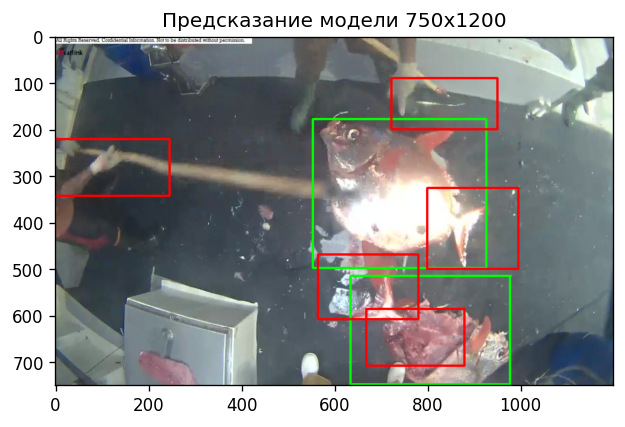

In [ ]:
annotation = boxes['lag'][0]

_, sample_img = load_img(annotation['filename'])
pred = model.predict(np.array([sample_img,]))

decoded = decode_prediction(pred[0], conf_thr=0.2)
decoded = non_max_suppression(decoded,
                              max_output_size=5,
                              iou_threshold=0.1)

plt.figure(figsize=(6, 6), dpi=120)
img = draw_boxes(annotation, decoded, (IMG_WIDTH, IMG_HEIGHT))
plt.imshow(img)
plt.title('Предсказание модели {}x{}'.format(*img.shape));

## Визуализируем предсказание на тесте

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


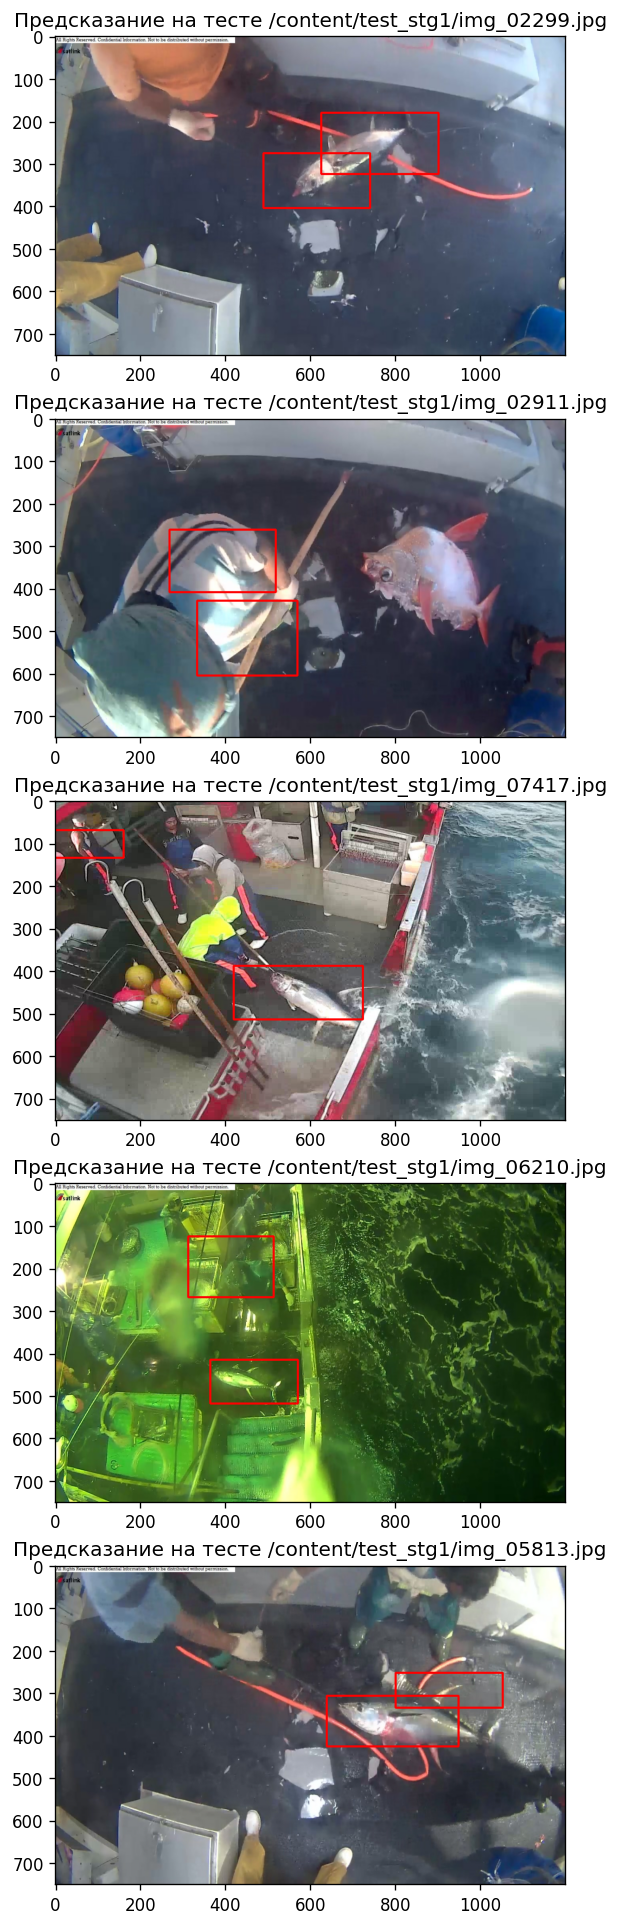

In [ ]:
test_images = glob('/content/test_stg1/*.jpg')[:5]


plt.figure(figsize=(6, 4 * len(test_images)), dpi=120)

for i, filename in enumerate(test_images):
    _, sample_img = load_img(filename)
    pred = model.predict(np.array([sample_img,]))

    decoded = decode_prediction(pred[0], conf_thr=0.0)
    decoded = non_max_suppression(decoded,
                                  max_output_size=2,
                                  iou_threshold=0.1)

    plt.subplot(len(test_images), 1, i + 1)
    img = draw_boxes({'filename': filename}, decoded, (IMG_WIDTH, IMG_HEIGHT))
    plt.imshow(img)
    plt.title('Предсказание на тесте {}'.format(filename));

## Агрегация результатов

In [ ]:
# TODO: предскажите класс рыбы для фотографии из тестовой выборки
#
# Подготовьте файл с предсказаниями вероятностей для каждой фотографии:
# image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
# img_00001.jpg,1,0,0,0,0,...,0
# img_00002.jpg,0.3,0.1,0.6,0,...,0

##**ResNet - first base model**

In [ ]:
from tensorflow.keras.applications import inception_resnet_v2
from tensorflow.keras.utils import to_categorical

In [ ]:
IMG_SIZE = (1200, 750)  # размер входного изображения сети

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return inception_resnet_v2.preprocess_input(img)

# функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=32):
    batch_size = min(len(files), batch_size)
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            X = np.array([load_image(path) for path in files[i:j]])
            y = to_categorical([classes[path.split('/')[-2]] for path in files[i:j]], 8)
            yield (X, y)

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)]),

In [ ]:
from random import choices

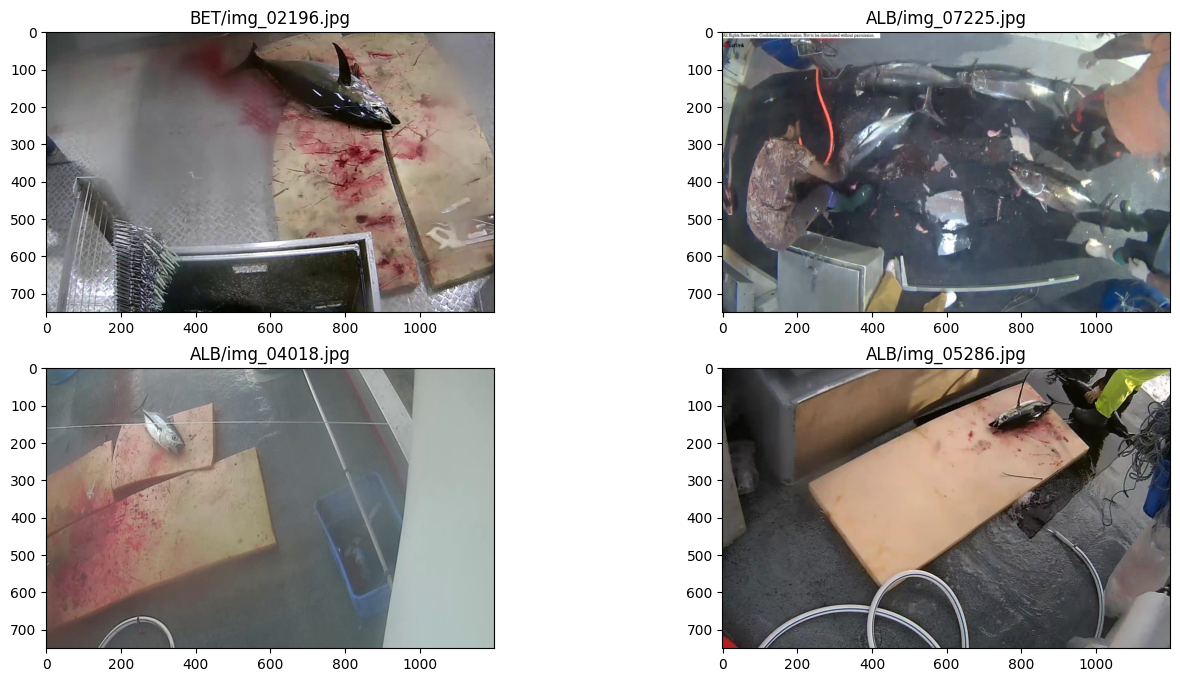

In [ ]:
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(choices(train_files, k=4), 1):
    subplot = fig.add_subplot(2, 2, i)
    subplot.set_title('%s' % path.split('/', 3)[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

In [ ]:
base_model = inception_resnet_v2.InceptionResNetV2(weights='imagenet',
                                                   include_top=False,
                                                   input_shape=(IMG_SIZE[1], IMG_SIZE[0], 3))

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

x = base_model.layers[-1].output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(8, activation='softmax', kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x)

In [ ]:
model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'fishdetector_resnet.keras',
    monitor='loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq=10)

val_samples = 32  # число изображений в валидационной выборке

shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])  # данные читаем функцией-генератором

# запускаем процесс обучения
model.fit(train_data,
          steps_per_epoch=10,
          epochs=100,
          validation_data=validation_data,
          callbacks=[checkpoint]
          )

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3017 - loss: 86.3983

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:199: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=self._current_epoch, batch=batch, logs=logs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 157s 5s/step - accuracy: 0.3075 - loss: 86.4854 - val_accuracy: 0.4375 - val_loss: 56.8069
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.5503 - loss: 35.9885 - val_accuracy: 0.8125 - val_loss: 20.9054
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.7387 - loss: 19.0273 - val_accuracy: 0.8125 - val_loss: 16.6361
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.8509 - loss: 9.6565 - val_accuracy: 0.8125 - val_loss: 13.9831
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - accuracy: 0.8612 - loss: 12.7156 - val_accuracy: 0.8125 - val_loss: 14.9436
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.8931 - loss: 9.7117 - val_accuracy: 0.8438 - val_loss: 17.5298
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - accuracy: 0.9001 - loss: 9.9001 - val_accuracy: 0.8125 - val_loss: 15.5152
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.8776 - loss: 8.0003 - val_accuracy: 0.8125 - v

In [ ]:
test_pred = model.predict(predict_generator(test_files), steps=len(test_files))

13153/13153 ━━━━━━━━━━━━━━━━━━━━ 1278s 97ms/step


In [ ]:
model.save('fishdetector_resnet.keras')
# model_loaded = keras.models.load_model('/content/fishdetector_resnet.keras')

In [ ]:
with open('submit_3.csv', 'w') as dst:
    dst.write('image,'+','.join(classes.keys())+'\n')
    for path, probas in zip(test_files, test_pred):
        probas = ','.join([f'{x:f}' for x in probas])
        dst.write(f'{path[9:]},{probas}\n')

!cp submit_3.csv 'drive/My Drive/'

Для Каггла требуется немного скорректировать наименование файлов в столбце image.

In [ ]:
df_csv = pd.read_csv('/content/submit_3.csv')
df_csv

image  SHARK  OTHER  ALB  LAG  YFT  BET  NoF  DOL
0        test_stg1/img_04271.jpg    0.0    0.0  0.0  0.0  0.0  0.0  1.0  0.0
1        test_stg1/img_01716.jpg    0.0    0.0  0.0  0.0  0.0  0.0  1.0  0.0
2        test_stg1/img_01632.jpg    0.0    0.0  1.0  0.0  0.0  0.0  0.0  0.0
3        test_stg1/img_07561.jpg    0.0    0.0  1.0  0.0  0.0  0.0  0.0  0.0
4        test_stg1/img_05967.jpg    0.0    0.0  1.0  0.0  0.0  0.0  0.0  0.0
...                          ...    ...    ...  ...  ...  ...  ...  ...  ...
13148  test_stg2/image_09192.jpg    0.0    0.0  1.0  0.0  0.0  0.0  0.0  0.0
13149  test_stg2/image_07197.jpg    0.0    0.0  0.0  0.0  0.0  0.0  1.0  0.0
13150  test_stg2/image_07094.jpg    0.0    0.0  0.0  0.0  0.0  0.0  0.0  1.0
13151  test_stg2/image_07642.jpg    0.0    0.0  0.0  0.0  0.0  0.0  0.0  1.0
13152  test_stg2/image_00900.jpg    0.0    0.0  0.0  0.0  0.0  0.0  1.0  0.0

[13153 rows x 9 columns]

In [ ]:
df_csv['image'] = df_csv['image'].replace(to_replace ='test_stg1/', value = '', regex = True)

In [ ]:
df_csv

image  SHARK  OTHER  ALB  LAG  YFT  BET  NoF  DOL
0                  img_04271.jpg    0.0    0.0  0.0  0.0  0.0  0.0  1.0  0.0
1                  img_01716.jpg    0.0    0.0  0.0  0.0  0.0  0.0  1.0  0.0
2                  img_01632.jpg    0.0    0.0  1.0  0.0  0.0  0.0  0.0  0.0
3                  img_07561.jpg    0.0    0.0  1.0  0.0  0.0  0.0  0.0  0.0
4                  img_05967.jpg    0.0    0.0  1.0  0.0  0.0  0.0  0.0  0.0
...                          ...    ...    ...  ...  ...  ...  ...  ...  ...
13148  test_stg2/image_09192.jpg    0.0    0.0  1.0  0.0  0.0  0.0  0.0  0.0
13149  test_stg2/image_07197.jpg    0.0    0.0  0.0  0.0  0.0  0.0  1.0  0.0
13150  test_stg2/image_07094.jpg    0.0    0.0  0.0  0.0  0.0  0.0  0.0  1.0
13151  test_stg2/image_07642.jpg    0.0    0.0  0.0  0.0  0.0  0.0  0.0  1.0
13152  test_stg2/image_00900.jpg    0.0    0.0  0.0  0.0  0.0  0.0  1.0  0.0

[13153 rows x 9 columns]

In [ ]:
df_csv.to_csv('submit_5.csv', index=False)

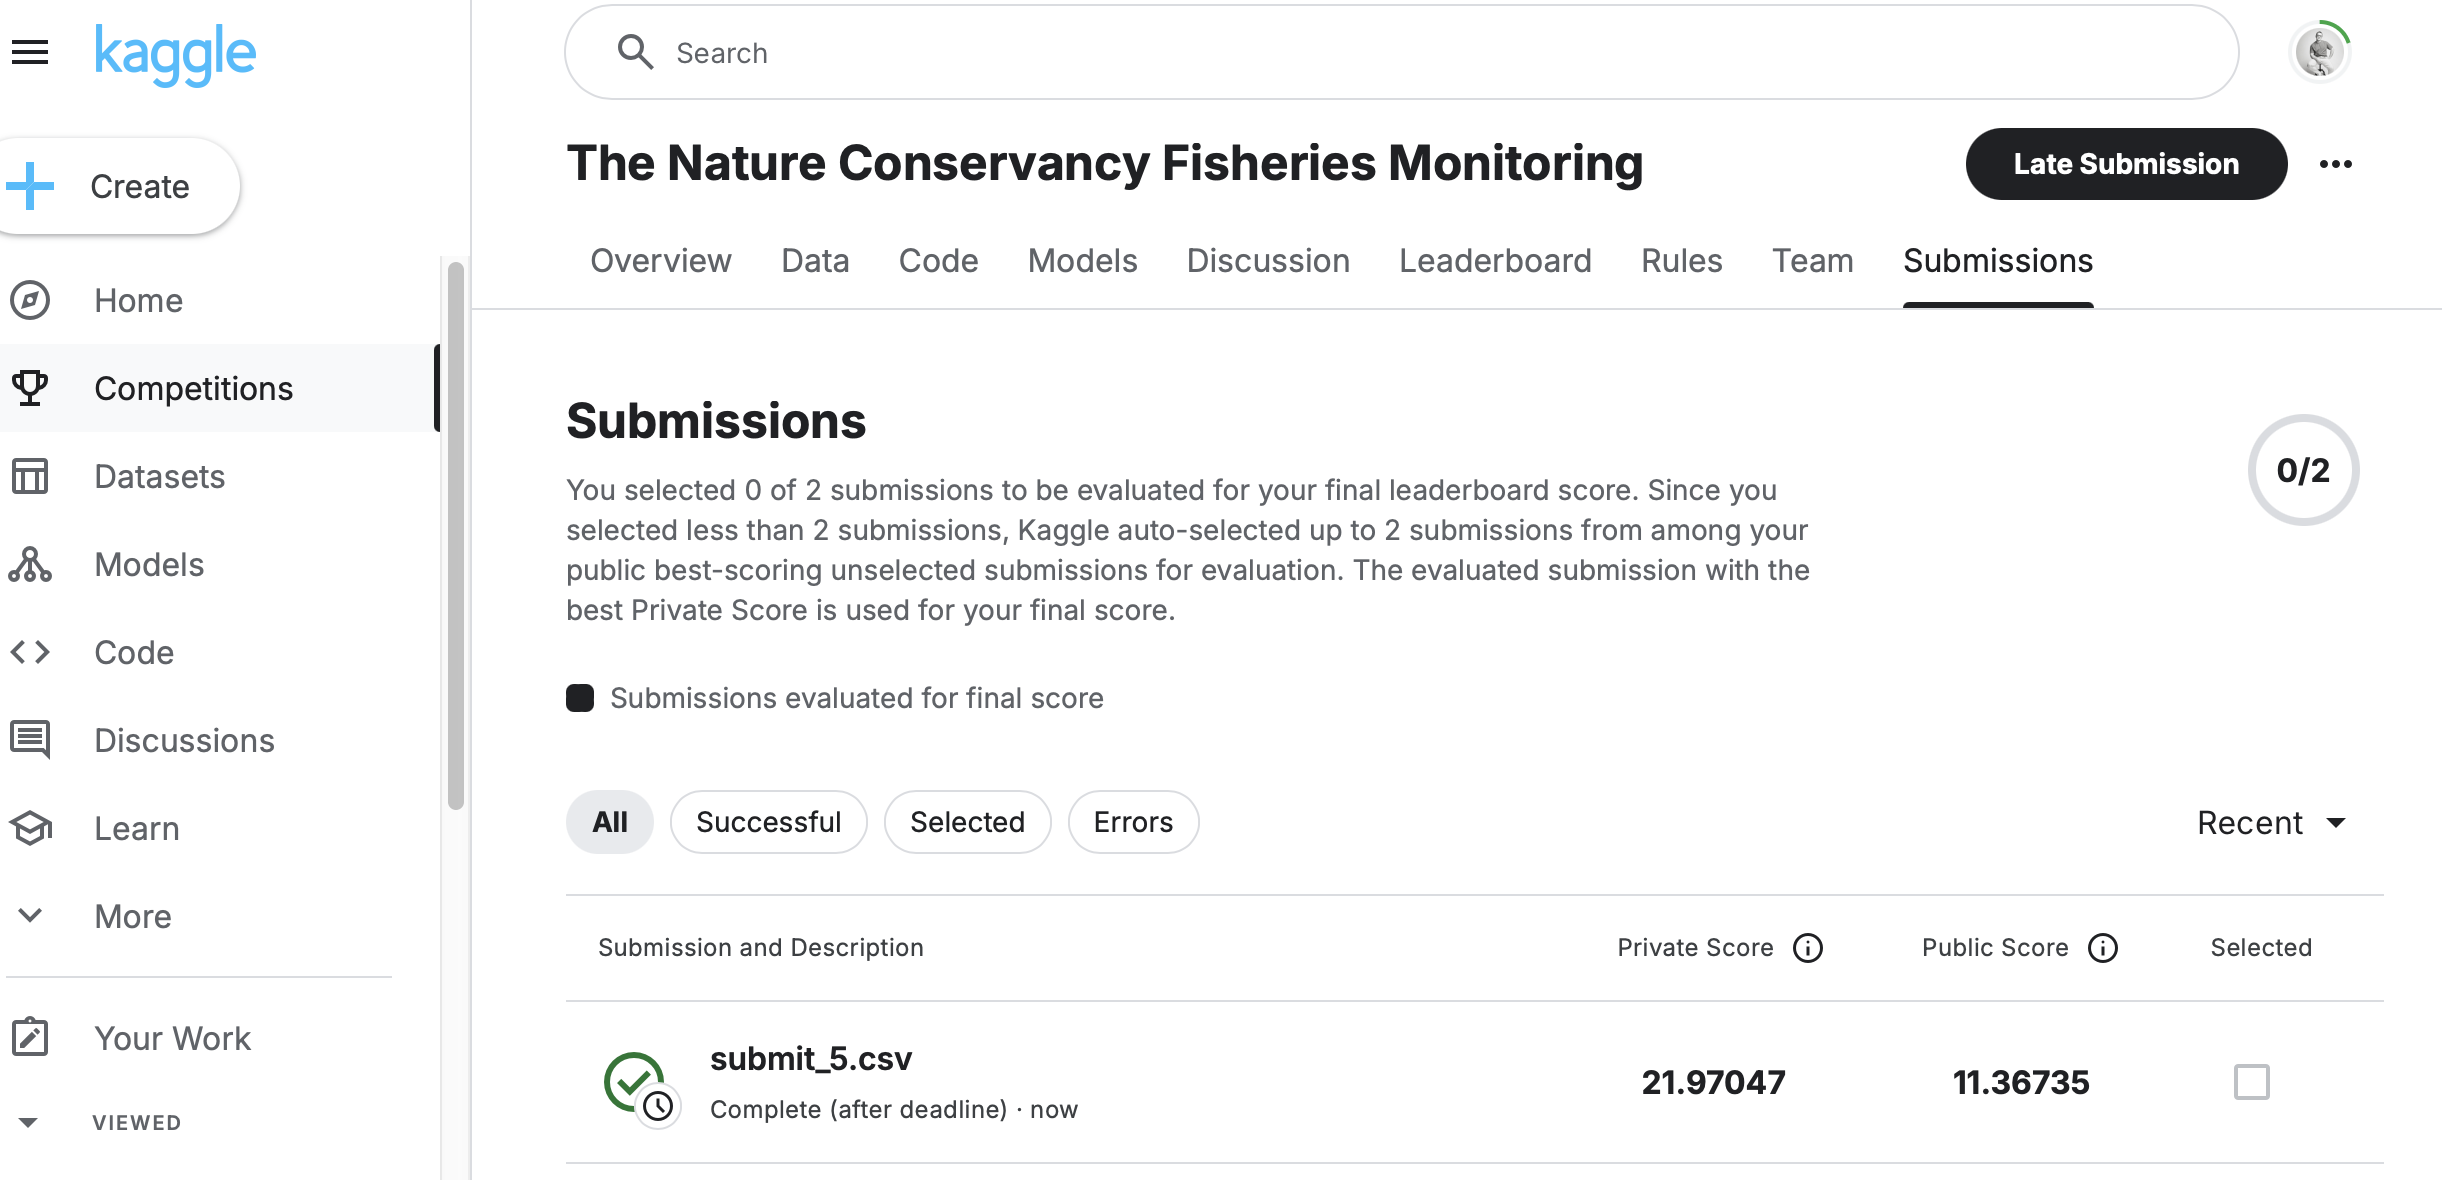

In [ ]:
from IPython.display import Image
Image('/content/Снимок экрана 2025-01-16 в 16.40.04.png')


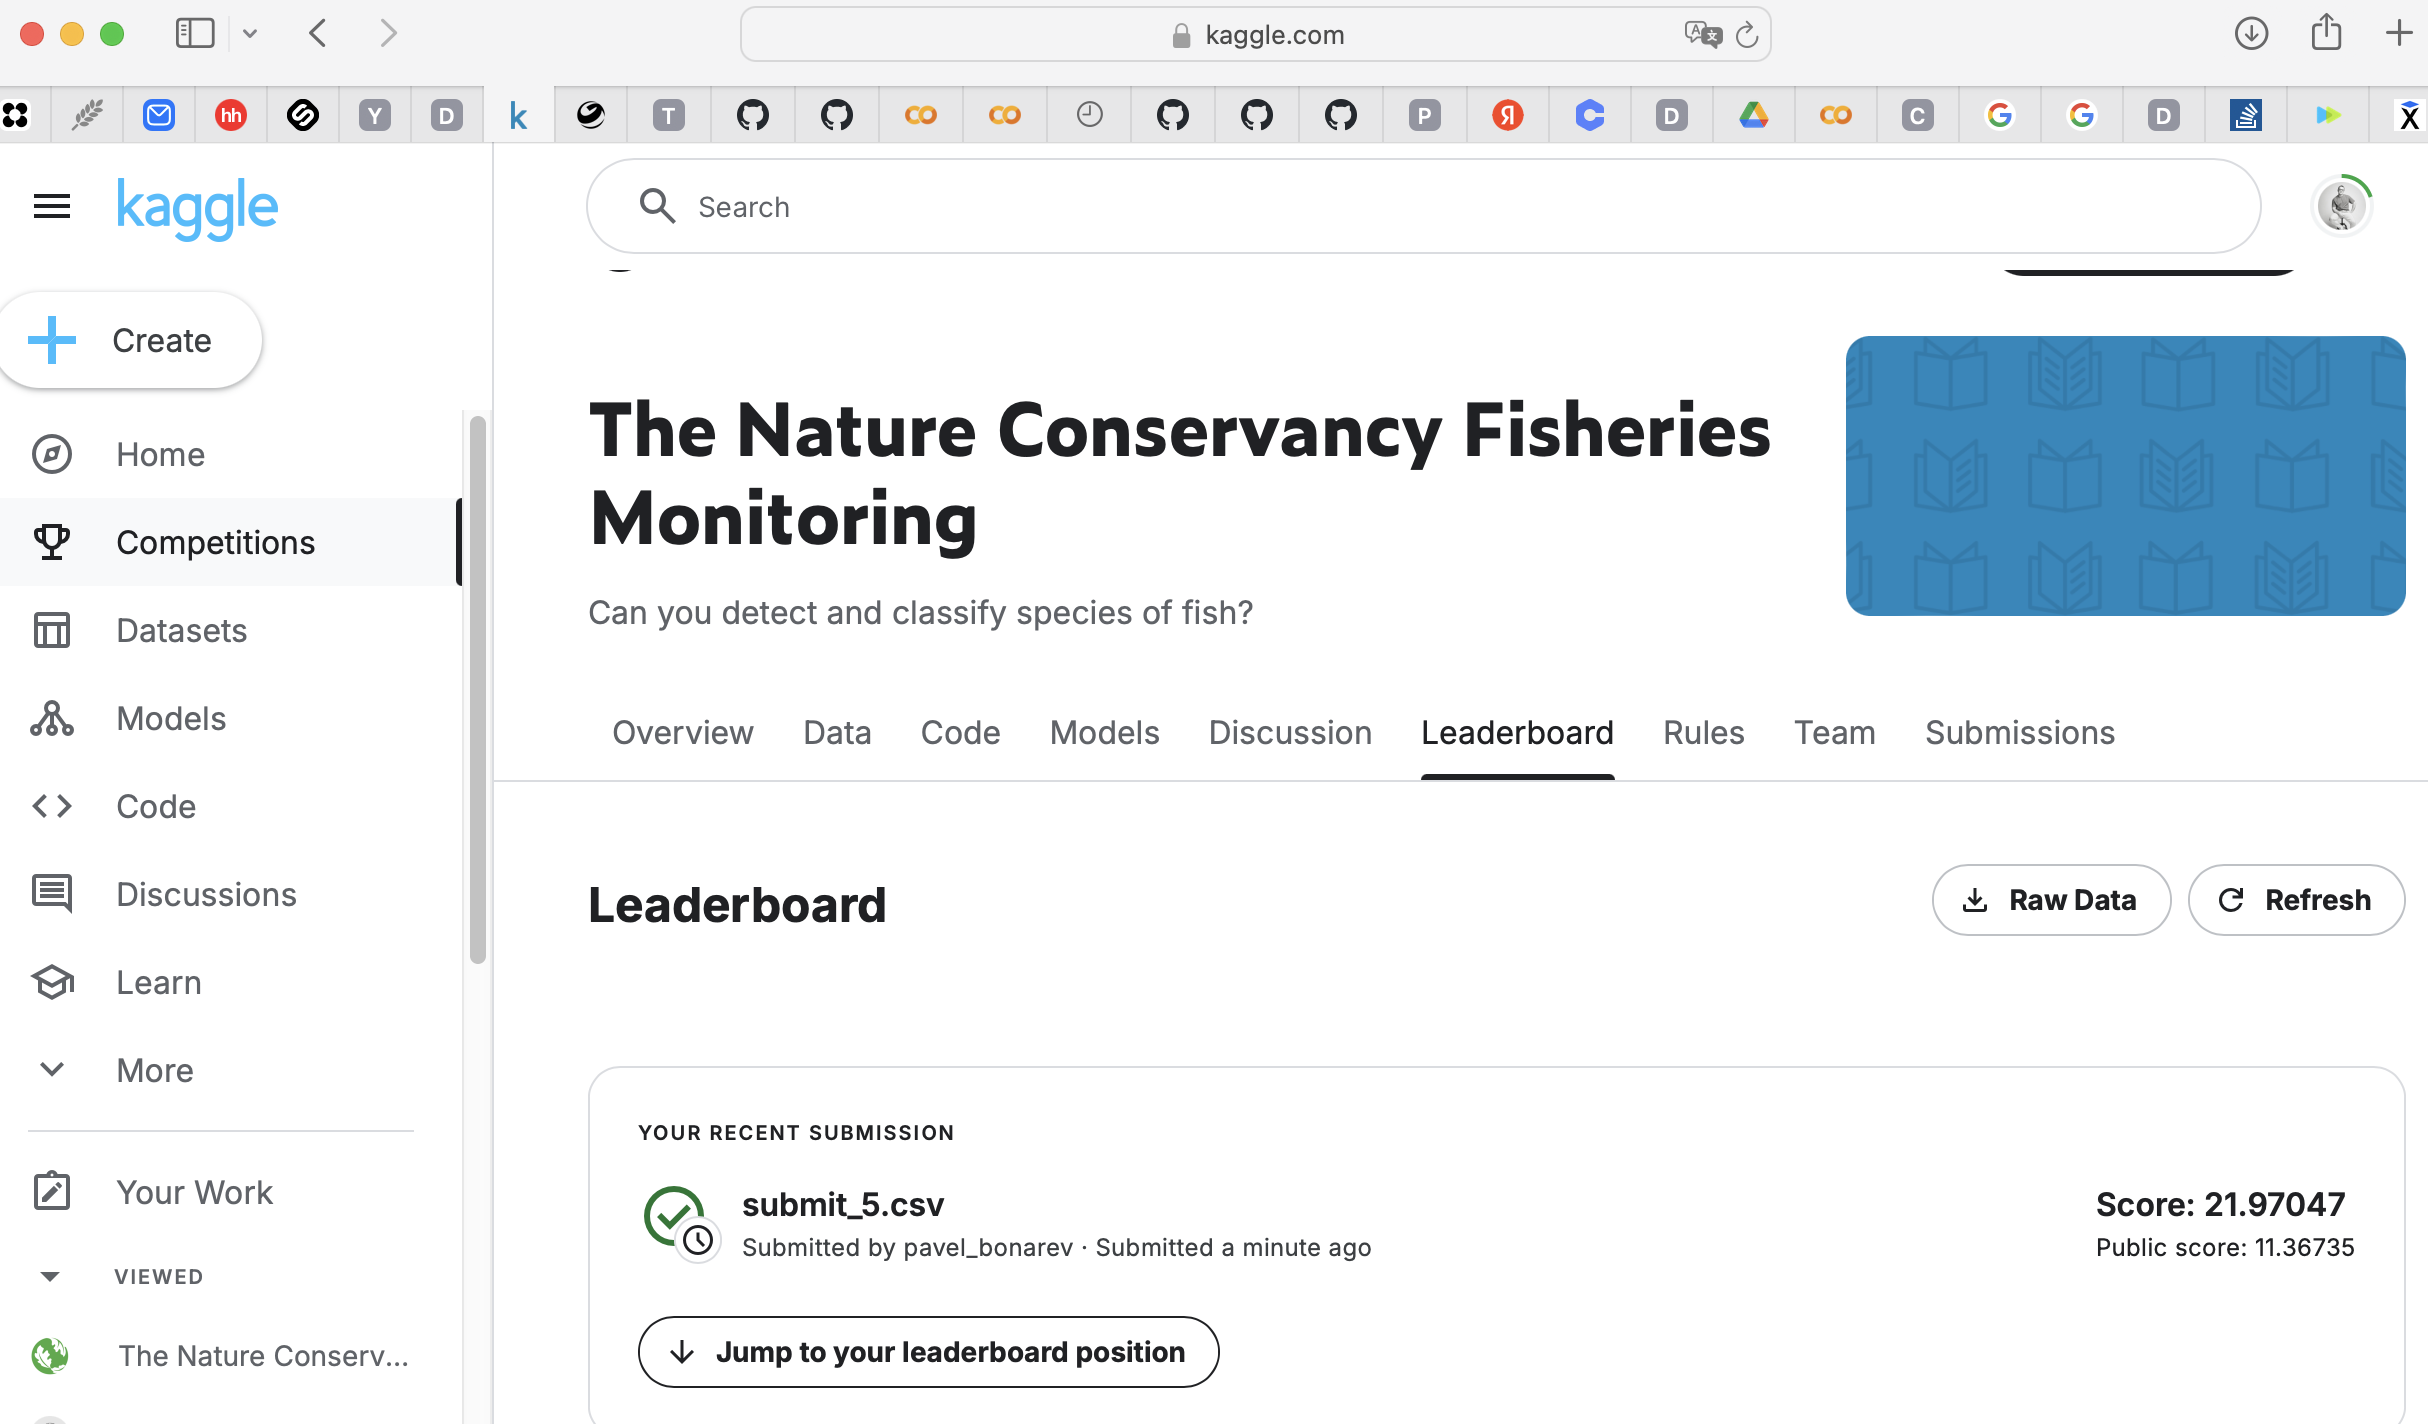

In [ ]:
Image('/content/Снимок экрана 2025-01-16 в 16.40.32.png')